In [1]:
import pandas as pd
print(f'Pandas {pd.__version__}')

import numpy as np
print(f'Numpy {np.__version__}')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
print(f'Tensorflow {tf.__version__}')

import sklearn
from sklearn.preprocessing import MinMaxScaler
print(f'Sklearn {sklearn.__version__}')

import matplotlib
import matplotlib.pyplot as plt
print(f'Matplotlib {matplotlib.__version__}')

Pandas 1.3.5
Numpy 1.21.5
Tensorflow 2.8.0
Sklearn 1.0.2
Matplotlib 3.2.2


In [2]:
np.random.seed(1234)
tf.random.set_seed(5678)
random_state_seed = 1337

# DATA PREPARATION

In [3]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv') 
#https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv
#LandAverageTemperature: global average land temperature in celsius
df = df[df['Country']=='Thailand']
df = df.reset_index(drop=True)
#display(df)

#print(df.isnull().sum())
#display(df[df['AverageTemperature'].isnull()])
#display(df[df['AverageTemperatureUncertainty'].isnull()])

#^uncomment the code above to see NaN data start from index 46 (1820-01-01) to 561 (1862-12-01) and 2370 (2013-09-01)
df = df[562:-1] #so we use data from index 562 to 2369
df = df.reset_index(drop=True)
print(df.isnull().sum())
df

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1863-01-01,22.806,2.022,Thailand
1,1863-02-01,24.700,2.396,Thailand
2,1863-03-01,26.599,0.854,Thailand
3,1863-04-01,27.646,1.523,Thailand
4,1863-05-01,27.756,1.296,Thailand
...,...,...,...,...
1803,2013-04-01,29.885,0.234,Thailand
1804,2013-05-01,29.548,0.286,Thailand
1805,2013-06-01,28.325,0.207,Thailand
1806,2013-07-01,27.564,0.318,Thailand


In [4]:
column_data = df['AverageTemperature']

def convertToMatrix(data, feature_timestep):
    x, y = [], []
    for i in range(len(df)-feature_timestep):
        d = i+feature_timestep
        x.append(data[i:d])
        y.append(data[d])
    return np.array(x), np.array(y)
model_structure = 'DEEP LSTM'

# 4 TIMESTEPS

In [5]:
feature_timestep = 4
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

4 Features
Data Length for 4 Features: 1804
Length x=y: True
4 Features x shape: (1804, 4)
4 Features y shape: (1804,)


In [6]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
4 Features Trainset Shape: (1443, 4) (1443,)
4 Features Valset Shape: (181, 4) (181,)
4 Features Testset Shape: (180, 4) (180,)


In [7]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1443, 4)
(181, 4)
(180, 4)
x shape after newaxis
(1443, 4, 1)
(181, 4, 1)
(180, 4, 1)
y shape
(1443, 1)
(181, 1)
(180, 1)


In [8]:
#deep LSTM model
model = Sequential()

model.add(LSTM(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         66560     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


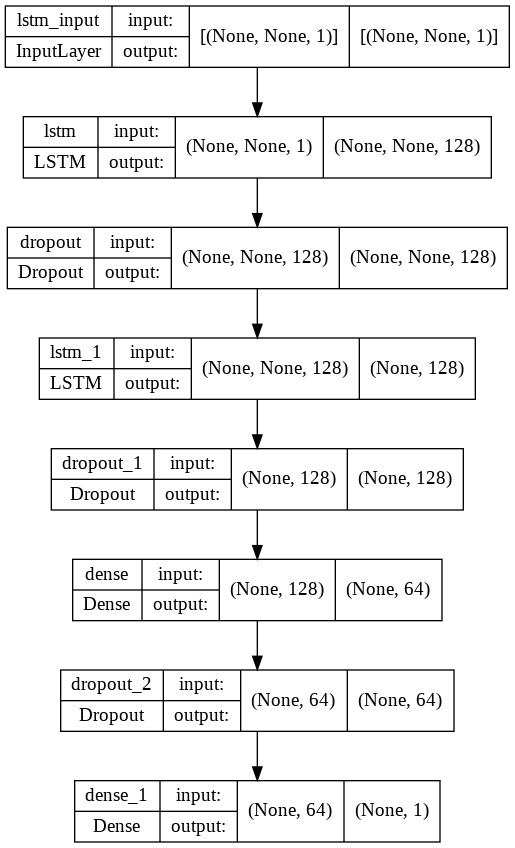

In [9]:
tf.keras.utils.plot_model(model, to_file = 'Model_LSTM.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [10]:
# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Epoch 1/100
145/145 [==============================] - 13s 14ms/step - loss: 0.1963 - mean_absolute_error: 0.1963 - val_loss: 0.1543 - val_mean_absolute_error: 0.1543
Epoch 2/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1598 - mean_absolute_error: 0.1598 - val_loss: 0.1229 - val_mean_absolute_error: 0.1229
Epoch 3/100
145/145 [==============================] - 1s 8ms/step - loss: 0.1394 - mean_absolute_error: 0.1394 - val_loss: 0.1005 - val_mean_absolute_error: 0.1005
Epoch 4/100
145/145 [==============================] - 1s 8ms/step - loss: 0.1206 - mean_absolute_error: 0.1206 - val_loss: 0.0872 - val_mean_absolute_error: 0.0872
Epoch 5/100
145/145 [==============================] - 1s 8ms/step - loss: 0.1134 - mean_absolute_error: 0.1134 - val_loss: 0.0867 - val_mean_absolute_error: 0.0867
Epoch 6/100
145/145 [==============================] - 1s 8ms/step - loss: 0.1089 - mean_absolute_error: 0.1089 - val_loss: 0.0792 - val_mean_absolute_error: 0.0792
Epoch 7/

In [11]:
#training detail
history.history

{'loss': [0.19634582102298737,
  0.15984603762626648,
  0.1394263654947281,
  0.12062644958496094,
  0.11339060962200165,
  0.1089438945055008,
  0.10705836862325668,
  0.10381671786308289,
  0.101460762321949,
  0.09684018790721893,
  0.09873495250940323,
  0.09796316176652908,
  0.09331857413053513,
  0.09545458853244781,
  0.0886993333697319,
  0.08904028683900833,
  0.08804809302091599,
  0.0882079005241394,
  0.08769930154085159,
  0.08404926210641861,
  0.08690362423658371,
  0.08349249511957169,
  0.08305718004703522,
  0.08065050095319748,
  0.08251442760229111,
  0.08161819726228714,
  0.07772374898195267,
  0.07971935719251633,
  0.07908976078033447,
  0.07731079310178757,
  0.07794805616140366,
  0.07702033966779709,
  0.07566649466753006,
  0.07551942765712738,
  0.07467959076166153,
  0.07390273362398148,
  0.07497993111610413,
  0.07337211817502975,
  0.0723346397280693,
  0.07243921607732773,
  0.0728432834148407,
  0.07175865769386292,
  0.0707072913646698,
  0.06886941

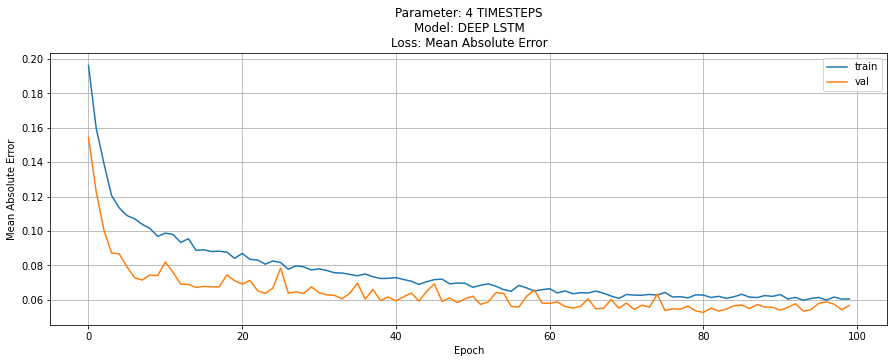

In [12]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [13]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

# RNN
# 6/6 [==============================] - 0s 10ms/step - loss: 0.0784 - mean_absolute_error: 0.0784
# Model LOSS=0.07839830964803696, METRIC=0.07839830964803696

6/6 [==============================] - 0s 4ms/step - loss: 0.0566 - mean_absolute_error: 0.0566
Model LOSS=0.056644268333911896, METRIC=0.056644268333911896


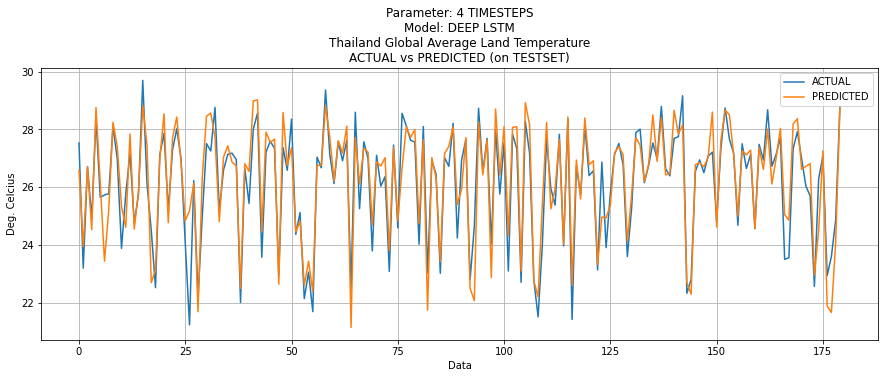

In [14]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [15]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.5761288404464722


# 6 TIMESTEPS

In [16]:
feature_timestep = 6
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

6 Features
Data Length for 6 Features: 1802
Length x=y: True
6 Features x shape: (1802, 6)
6 Features y shape: (1802,)


In [17]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
6 Features Trainset Shape: (1441, 6) (1441,)
6 Features Valset Shape: (181, 6) (181,)
6 Features Testset Shape: (180, 6) (180,)


In [18]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1441, 6)
(181, 6)
(180, 6)
x shape after newaxis
(1441, 6, 1)
(181, 6, 1)
(180, 6, 1)
y shape
(1441, 1)
(181, 1)
(180, 1)


In [19]:
#deep LSTM model
model = Sequential()

model.add(LSTM(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 128)         66560     
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Epoch 1/100
145/145 [==============================] - 8s 15ms/step - loss: 0.1734 - mean_absolute_error: 0.1734 - val_loss: 0.1230 - val_mean_absolute_error: 0.1230
Epoch 2/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1407 - mean_absolute_error: 0.1407 - val_loss: 0.1226 - val_mean_absolute_error: 0.1226
Epoch 3/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1322 - mean_absolute_error: 0.1322 - val_loss: 0.1135 - val_mean_absolute_error: 0.1135
Epoch 4/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1242 - mean_absolute_error: 0.1242 - val_loss: 0.1046 - val_mean_absolute_error: 0.1046
Epoch 5/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.0948 - val_mean_absolute_error: 0.0948
Epoch 6/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1095 - mean_absolute_error: 0.1095 - val_loss: 0.0966 - val_mean_absolute_error: 0.0966
Epoch 7/1

In [22]:
#training detail
history.history

{'loss': [0.1733972281217575,
  0.14067435264587402,
  0.1321762204170227,
  0.12422250211238861,
  0.1192060112953186,
  0.10954335331916809,
  0.10923800617456436,
  0.10179717093706131,
  0.10181166231632233,
  0.10036741197109222,
  0.09537866711616516,
  0.09453101456165314,
  0.09357751160860062,
  0.09107789397239685,
  0.09089943021535873,
  0.09078042209148407,
  0.08891221135854721,
  0.08737034350633621,
  0.08854535967111588,
  0.08379588276147842,
  0.08311240375041962,
  0.0857185646891594,
  0.0840597078204155,
  0.08187338709831238,
  0.08219681680202484,
  0.08036627620458603,
  0.07989075034856796,
  0.0780869871377945,
  0.0760212168097496,
  0.07685153931379318,
  0.07326140254735947,
  0.07532026618719101,
  0.07024496048688889,
  0.07335084676742554,
  0.07135383039712906,
  0.06999151408672333,
  0.07048945128917694,
  0.06863334029912949,
  0.06899558752775192,
  0.06670685857534409,
  0.06893133372068405,
  0.06478218734264374,
  0.06609329581260681,
  0.065205

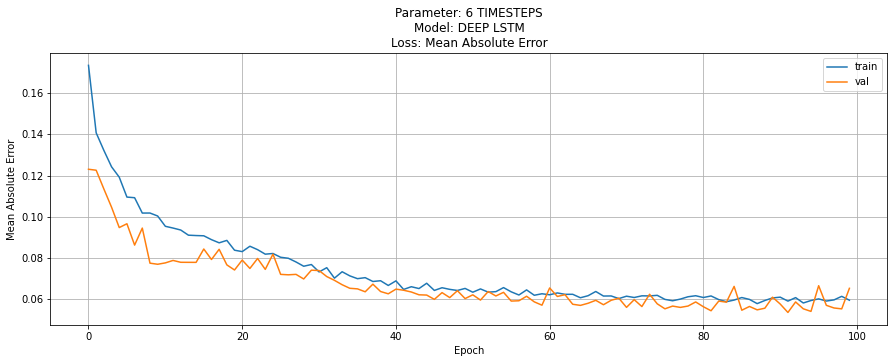

In [23]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [24]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 5ms/step - loss: 0.0485 - mean_absolute_error: 0.0485
Model LOSS=0.04845917597413063, METRIC=0.04845917597413063


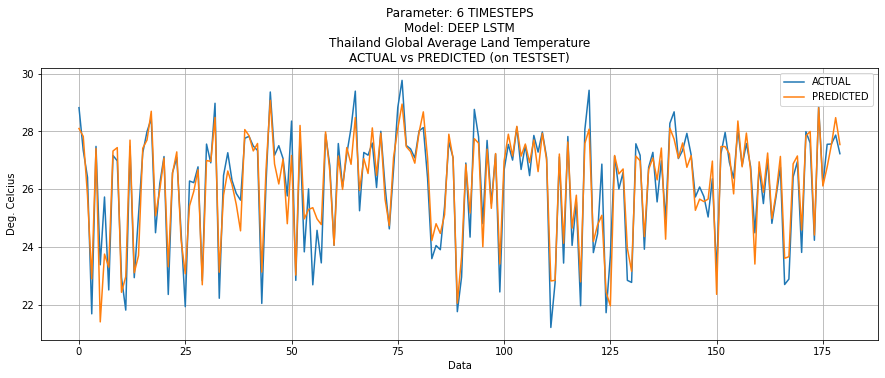

In [25]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [26]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.49287834763526917


# 12 TIMESTEPS

In [27]:
feature_timestep = 12
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

12 Features
Data Length for 12 Features: 1796
Length x=y: True
12 Features x shape: (1796, 12)
12 Features y shape: (1796,)


In [28]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
12 Features Trainset Shape: (1436, 12) (1436,)
12 Features Valset Shape: (181, 12) (181,)
12 Features Testset Shape: (179, 12) (179,)


In [29]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1436, 12)
(181, 12)
(179, 12)
x shape after newaxis
(1436, 12, 1)
(181, 12, 1)
(179, 12, 1)
y shape
(1436, 1)
(181, 1)
(179, 1)


In [30]:
#deep LSTM model
model = Sequential()

model.add(LSTM(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 128)         66560     
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Epoch 1/100
144/144 [==============================] - 6s 18ms/step - loss: 0.2114 - mean_absolute_error: 0.2114 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470
Epoch 2/100
144/144 [==============================] - 2s 12ms/step - loss: 0.1610 - mean_absolute_error: 0.1610 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 3/100
144/144 [==============================] - 2s 12ms/step - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.0882 - val_mean_absolute_error: 0.0882
Epoch 4/100
144/144 [==============================] - 2s 12ms/step - loss: 0.1105 - mean_absolute_error: 0.1105 - val_loss: 0.0706 - val_mean_absolute_error: 0.0706
Epoch 5/100
144/144 [==============================] - 2s 12ms/step - loss: 0.0968 - mean_absolute_error: 0.0968 - val_loss: 0.0695 - val_mean_absolute_error: 0.0695
Epoch 6/100
144/144 [==============================] - 2s 12ms/step - loss: 0.0969 - mean_absolute_error: 0.0969 - val_loss: 0.0666 - val_mean_absolute_error: 0.0666
Epoc

In [32]:
#training detail
history.history

{'loss': [0.2113761305809021,
  0.1610005497932434,
  0.11918298155069351,
  0.11050814390182495,
  0.09680081903934479,
  0.09692446887493134,
  0.09557432681322098,
  0.09192943572998047,
  0.08771669864654541,
  0.08617789298295975,
  0.08304435014724731,
  0.0821072980761528,
  0.08027943968772888,
  0.07923762500286102,
  0.07597528398036957,
  0.07554713636636734,
  0.07450556010007858,
  0.07682165503501892,
  0.07135547697544098,
  0.0706854909658432,
  0.06999549269676208,
  0.06897415220737457,
  0.0701717883348465,
  0.06789141148328781,
  0.06863337755203247,
  0.06858580559492111,
  0.0667167529463768,
  0.06400055438280106,
  0.06645669043064117,
  0.06478478014469147,
  0.06129642203450203,
  0.06615734100341797,
  0.06484296917915344,
  0.06175147369503975,
  0.06043257191777229,
  0.059995364397764206,
  0.0624721460044384,
  0.06028495728969574,
  0.06054281070828438,
  0.05969611182808876,
  0.060262229293584824,
  0.05984600633382797,
  0.05999719724059105,
  0.0602

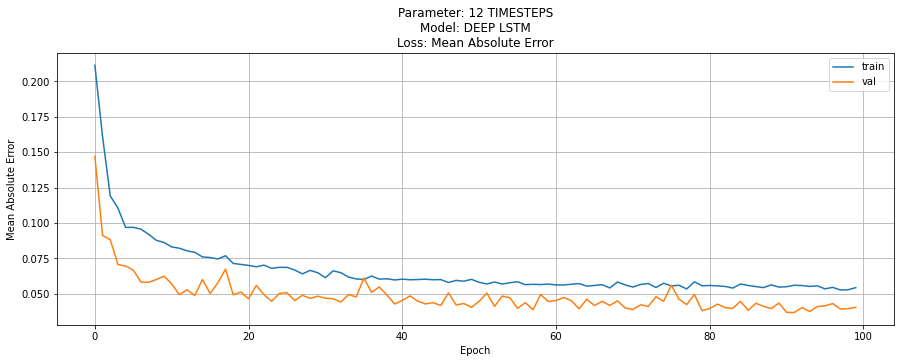

In [33]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [34]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 6ms/step - loss: 0.0425 - mean_absolute_error: 0.0425
Model LOSS=0.04253993183374405, METRIC=0.04253993183374405


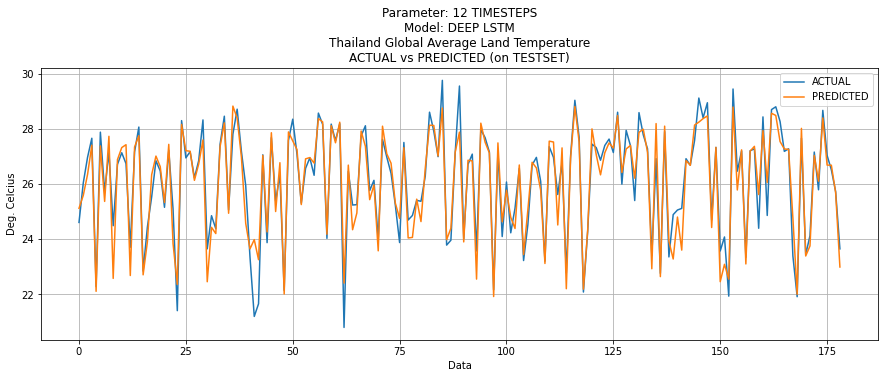

In [35]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [36]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.43267378211021423
